# Exercise 8 - Recurrent Neural networks


This exercise is based on https://github.com/leriomaggio/deep-learning-keras-tensorflow and https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py and https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

<img src="rnn.png" width="20%">

A recurrent neural network (RNN) is a class of artificial neural network where connections between units form a directed cycle. This creates an internal state of the network which allows it to exhibit dynamic temporal behavior.

```python
keras.layers.recurrent.SimpleRNN(units, activation='tanh', use_bias=True, 
                                 kernel_initializer='glorot_uniform', 
                                 recurrent_initializer='orthogonal', 
                                 bias_initializer='zeros', 
                                 kernel_regularizer=None, 
                                 recurrent_regularizer=None, 
                                 bias_regularizer=None, 
                                 activity_regularizer=None, 
                                 kernel_constraint=None, recurrent_constraint=None, 
                                 bias_constraint=None, dropout=0.0, recurrent_dropout=0.0)
```

#### Arguments:

<ul>
<li><strong>units</strong>: Positive integer, dimensionality of the output space.</li>
<li><strong>activation</strong>: Activation function to use
    (see <a href="http://keras.io/activations/">activations</a>).
    If you pass None, no activation is applied
    (ie. "linear" activation: <code>a(x) = x</code>).</li>
<li><strong>use_bias</strong>: Boolean, whether the layer uses a bias vector.</li>
<li><strong>kernel_initializer</strong>: Initializer for the <code>kernel</code> weights matrix,
    used for the linear transformation of the inputs.
    (see <a href="https://keras.io/initializers/">initializers</a>).</li>
<li><strong>recurrent_initializer</strong>: Initializer for the <code>recurrent_kernel</code>
    weights matrix,
    used for the linear transformation of the recurrent state.
    (see <a href="https://keras.io/initializers/">initializers</a>).</li>
<li><strong>bias_initializer</strong>: Initializer for the bias vector
    (see <a href="https://keras.io/initializers/">initializers</a>).</li>
<li><strong>kernel_regularizer</strong>: Regularizer function applied to
    the <code>kernel</code> weights matrix
    (see <a href="https://keras.io/regularizers/">regularizer</a>).</li>
<li><strong>recurrent_regularizer</strong>: Regularizer function applied to
    the <code>recurrent_kernel</code> weights matrix
    (see <a href="https://keras.io/regularizers/">regularizer</a>).</li>
<li><strong>bias_regularizer</strong>: Regularizer function applied to the bias vector
    (see <a href="https://keras.io/regularizers/">regularizer</a>).</li>
<li><strong>activity_regularizer</strong>: Regularizer function applied to
    the output of the layer (its "activation").
    (see <a href="https://keras.io/regularizers/">regularizer</a>).</li>
<li><strong>kernel_constraint</strong>: Constraint function applied to
    the <code>kernel</code> weights matrix
    (see <a href="https://keras.io/constraints/">constraints</a>).</li>
<li><strong>recurrent_constraint</strong>: Constraint function applied to
    the <code>recurrent_kernel</code> weights matrix
    (see <a href="https://keras.io/constraints/">constraints</a>).</li>
<li><strong>bias_constraint</strong>: Constraint function applied to the bias vector
    (see <a href="https://keras.io/constraints/">constraints</a>).</li>
<li><strong>dropout</strong>: Float between 0 and 1.
    Fraction of the units to drop for
    the linear transformation of the inputs.</li>
<li><strong>recurrent_dropout</strong>: Float between 0 and 1.
    Fraction of the units to drop for
    the linear transformation of the recurrent state.</li>
</ul>

#### Backprop Through time  

Contrary to feed-forward neural networks, the RNN is characterized by the ability of encoding longer past information, thus very suitable for sequential models. The BPTT extends the ordinary BP algorithm to suit the recurrent neural
architecture.

<img src="rnn2.png" width="45%">

**Reference**: [Backpropagation through Time](http://ir.hit.edu.cn/~jguo/docs/notes/bptt.pdf)

## IMDB sentiment classification task

The problem that we will use to demonstrate sequence learning in this tutorial is the IMDB movie review sentiment classification problem. Each movie review is a variable sequence of words and the sentiment of each movie review must be classified.

The Large Movie Review Dataset (often referred to as the IMDB dataset) contains 25,000 highly-polar movie reviews (good or bad) for training and the same amount again for testing. The problem is to determine whether a given movie review has a positive or negative sentiment.
http://ai.stanford.edu/~amaas/data/sentiment/

The data was collected by Stanford researchers and was used in a 2011 paper (http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf) where a split of 50-50 of the data was used for training and test. An accuracy of 88.89% was achieved.

Keras provides access to the IMDB dataset built-in. The imdb.load_data() function allows you to load the dataset in a format that is ready for use in neural network and deep learning models.

The words have been replaced by integers that indicate the ordered frequency of each word in the dataset. The sentences in each review are therefore comprised of a sequence of integers.



### Word Embedding
We will map each movie review into a real vector domain, a popular technique when working with text called word embedding. This is a technique where words are encoded as real-valued vectors in a high dimensional space, where the similarity between words in terms of meaning translates to closeness in the vector space.

Keras provides a convenient way to convert positive integer representations of words into a word embedding by an Embedding layer.

We will map each word onto a 32 length real valued vector. We will also limit the total number of words that we are interested in modeling to the 5000 most frequent words, and zero out the rest. Finally, the sequence length (number of words) in each review varies, so we will constrain each review to be 500 words, truncating long reviews and pad the shorter reviews with zero values.

Now that we have defined our problem and how the data will be prepared and modeled, we are ready to develop an LSTM model to classify the sentiment of movie reviews.

### Data Preparation - IMDB

In [1]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, SimpleRNN
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split

# fix random seed for reproducibility
numpy.random.seed(42)

/media/nackenho/Data/programs/ML/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


We need to load the IMDB dataset. We are constraining the dataset to the top 5,000 words. We also split the dataset into train (70%) and validation (30%) sets.

In [2]:
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
print("Loading data...")
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

print(len(X_test), 'test sequences')
print(len(X_train), 'train sequences')
print(len(X_val), 'validation sequences')
print('Example:')
print(X_train[:1])

Loading data...
(25000, 'test sequences')
(17500, 'train sequences')
(7500, 'validation sequences')
Example:
[list([1, 416, 9, 35, 576, 73, 93, 248, 201, 44, 49, 84, 15, 26, 416, 23, 35, 1111, 225, 38, 111, 1299, 5, 505, 15, 25, 191, 66, 1197, 37, 129, 1640, 109, 9, 31, 786, 94, 90, 95, 29, 127, 142, 38, 240, 2, 95, 2, 44, 8, 81, 142, 38, 2, 4, 2, 95, 836, 3861, 56, 5, 43, 17, 25, 26, 44, 8, 2, 4, 390, 630, 5, 129, 40, 2, 38, 25, 28, 8, 858, 6, 226, 1269, 99, 67, 4, 375, 390, 21, 12, 9, 290, 4, 858, 836, 206, 883, 1285, 94, 188, 12, 32, 972, 39, 4, 4245, 539, 21, 1584, 52, 17, 12, 817, 15, 25, 70, 165, 2, 23, 4, 65, 53, 5, 65, 9, 51, 14, 9, 32, 44, 38, 48, 25, 40, 6, 52, 65, 5, 40, 836, 14, 9, 6, 52, 31, 190, 3333, 13, 104, 9, 242, 128, 13, 28, 6, 733, 23, 15, 99, 15, 25, 100, 808, 12, 46, 13, 62, 202, 416, 6, 52, 709, 46, 7, 158, 1424, 88, 94, 38, 2, 25, 115, 124, 51, 80, 593, 375])]


Next, we need to truncate and pad the input sequences so that they are all the same length for modeling. The model will learn the zero values carry no information so indeed the sequences are not the same length in terms of content, but same length vectors is required to perform the computation in Keras.

In [3]:
# truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
X_val = sequence.pad_sequences(X_val, maxlen=max_review_length)
print('Example:')
print(X_train[:1])

Example:
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    

## A simple RNN model

In [4]:
print('Build model...')
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(Dropout(0.4))
model.add(SimpleRNN(128))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               20608     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 180,737
Trainable params: 180,737
Non-trainable params: 0
_________________________________________________________________
None


### Training

In [5]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=64)

Train on 17500 samples, validate on 7500 samples
Epoch 1/3
17500/17500 [==============================] - 73s 4ms/step - loss: 0.7373 - acc: 0.5044 - val_loss: 0.6944 - val_acc: 0.4933
Epoch 2/3
17500/17500 [==============================] - 76s 4ms/step - loss: 0.7287 - acc: 0.5077 - val_loss: 0.6801 - val_acc: 0.6117
Epoch 3/3
17500/17500 [==============================] - 73s 4ms/step - loss: 0.6636 - acc: 0.5838 - val_loss: 0.6202 - val_acc: 0.6356


In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

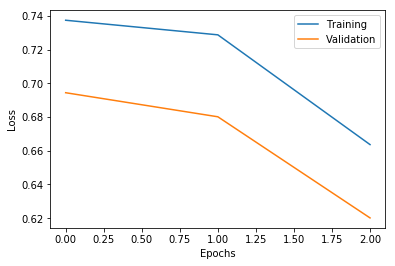

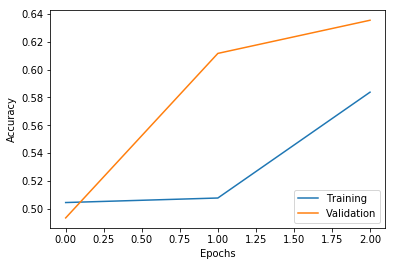

In [7]:
plot_history(history)

### Evaluation

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

def evaluate(X_test, Y_test, X_train, Y_train, model):
    
    ##Evaluate loss and metrics and predict & classes
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    Y_pred = model.predict(X_test, batch_size=1)
    Y_cls  = model.predict_classes(X_test, batch_size=1)
    
    print('Test Loss:', loss)
    print('Accuracy: %.2f' % accuracy_score(Y_test, Y_cls))
    print("Precision: %.2f" % precision_score(Y_test, Y_cls, average='weighted'))
    print("Recall: %.2f" % recall_score(Y_test, Y_cls, average='weighted'))
    print 'Classification Report:\n', classification_report(Y_test, Y_cls)
  
  
    ## Plot 0 probability including overtraining test
    plt.figure(figsize=(8,8))

    label=1
    #Test prediction
    plt.hist(Y_pred[Y_test == label], alpha=0.5, color='red', range=[0, 1], bins=10)
    plt.hist(Y_pred[Y_test != label], alpha=0.5, color='blue', range=[0, 1], bins=10)
    
    #Train prediction
    Y_train_pred = model.predict(X_train)
    plt.hist(Y_train_pred[Y_train == label], alpha=0.5, color='red', range=[0, 1], bins=10, histtype='step', linewidth=2)
    plt.hist(Y_train_pred[Y_train != label], alpha=0.5, color='blue', range=[0, 1], bins=10, histtype='step', linewidth=2)
    
    plt.legend(['train == 1', 'train == 0', 'test == 1', 'test == 0'], loc='upper right')
    plt.xlabel('Probability of being a good review')
    plt.ylabel('Number of entries')
    plt.show()


('Test Loss:', 0.6246966641426086)
Accuracy: 0.64
Precision: 0.66
Recall: 0.64
Classification Report:
             precision    recall  f1-score   support

          0       0.61      0.81      0.69      5027
          1       0.71      0.48      0.57      4973

avg / total       0.66      0.64      0.63     10000



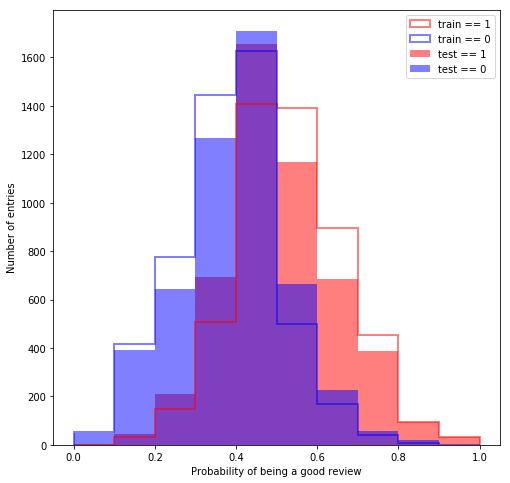

In [9]:
evaluate(X_test[:10000], y_test[:10000],X_train[:10000], y_train[:10000], model)

## LSTM model

A LSTM network is an artificial neural network that contains LSTM blocks instead of, or in addition to, regular network units. A LSTM block may be described as a "smart" network unit that can remember a value for an arbitrary length of time. 

Unlike traditional RNNs, an Long short-term memory network is well-suited to learn from experience to classify, process and predict time series when there are very long time lags of unknown size between important events.

```python
keras.layers.recurrent.LSTM(units, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, 
                            kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', 
                            bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, 
                            recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
                            kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, 
                            dropout=0.0, recurrent_dropout=0.0)
```

#### Arguments

<ul>
<li><strong>units</strong>: Positive integer, dimensionality of the output space.</li>
<li><strong>activation</strong>: Activation function to use
    If you pass None, no activation is applied
    (ie. "linear" activation: <code>a(x) = x</code>).</li>
<li><strong>recurrent_activation</strong>: Activation function to use
    for the recurrent step.</li>
<li><strong>use_bias</strong>: Boolean, whether the layer uses a bias vector.</li>
<li><strong>kernel_initializer</strong>: Initializer for the <code>kernel</code> weights matrix,
    used for the linear transformation of the inputs.</li>
<li><strong>recurrent_initializer</strong>: Initializer for the <code>recurrent_kernel</code>
    weights matrix,
    used for the linear transformation of the recurrent state.</li>
<li><strong>bias_initializer</strong>: Initializer for the bias vector.</li>
<li><strong>unit_forget_bias</strong>: Boolean.
    If True, add 1 to the bias of the forget gate at initialization.
    Setting it to true will also force <code>bias_initializer="zeros"</code>.
    This is recommended in <a href="http://www.jmlr.org/proceedings/papers/v37/jozefowicz15.pdf">Jozefowicz et al.</a></li>
<li><strong>kernel_regularizer</strong>: Regularizer function applied to
    the <code>kernel</code> weights matrix.</li>
<li><strong>recurrent_regularizer</strong>: Regularizer function applied to
    the <code>recurrent_kernel</code> weights matrix.</li>
<li><strong>bias_regularizer</strong>: Regularizer function applied to the bias vector.</li>
<li><strong>activity_regularizer</strong>: Regularizer function applied to
    the output of the layer (its "activation").</li>
<li><strong>kernel_constraint</strong>: Constraint function applied to
    the <code>kernel</code> weights matrix.</li>
<li><strong>recurrent_constraint</strong>: Constraint function applied to
    the <code>recurrent_kernel</code> weights matrix.</li>
<li><strong>bias_constraint</strong>: Constraint function applied to the bias vector.</li>
<li><strong>dropout</strong>: Float between 0 and 1.
    Fraction of the units to drop for
    the linear transformation of the inputs.</li>
<li><strong>recurrent_dropout</strong>: Float between 0 and 1.
    Fraction of the units to drop for
    the linear transformation of the recurrent state.</li>
</ul>

## Task 1: Train and evaluate an LSTM model
* Build a model using again one embedding layer and one dense output node but with an LSTM layer with 128 units instead of the RNN layer
* Use a dropout layer between the embedding and LSTM layer and between the LSTM and the dense layer
* Train the model and plot the loss and accuracy over epochs
* Evaluate the performance of the model and compare it with the RNN model

We can now define, compile and fit our LSTM model.

The first layer is the Embedded layer that uses 32 length vectors to represent each word. The next layer is the LSTM layer with 128 memory units (smart neurons). Finally, because this is a classification problem we use a Dense output layer with a single neuron and a sigmoid activation function to make 0 or 1 predictions for the two classes (good and bad) in the problem.

Because it is a binary classification problem, log loss is used as the loss function (binary_crossentropy in Keras). The efficient ADAM optimization algorithm is used. The model is fit for only 2 epochs because it quickly overfits the problem. A large batch size of 64 reviews is used to space out weight updates.

In [10]:
print('Build model...')
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(Dropout(0.4))
model.add(LSTM(128))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 242,561
Trainable params: 242,561
Non-trainable params: 0
_________________________________________________________________
None


### Training

In [11]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=64)

Train on 17500 samples, validate on 7500 samples
Epoch 1/3
17500/17500 [==============================] - 202s 12ms/step - loss: 0.5156 - acc: 0.7287 - val_loss: 0.3601 - val_acc: 0.8488
Epoch 2/3
17500/17500 [==============================] - 198s 11ms/step - loss: 0.3594 - acc: 0.8522 - val_loss: 0.3565 - val_acc: 0.8569
Epoch 3/3
17500/17500 [==============================] - 197s 11ms/step - loss: 0.2893 - acc: 0.8833 - val_loss: 0.3675 - val_acc: 0.8403


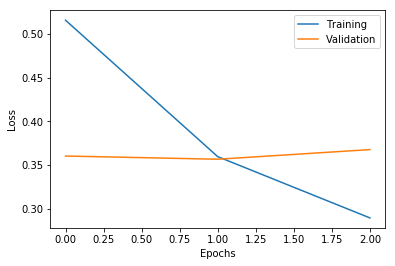

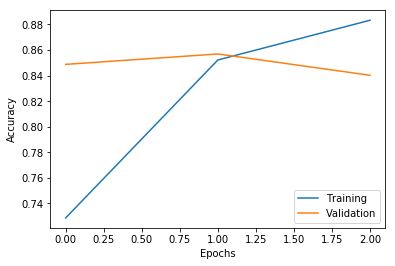

In [12]:
plot_history(history)

### Evaluation

('Test Loss:', 0.3655299718618393)
Accuracy: 0.84
Precision: 0.85
Recall: 0.84
Classification Report:
             precision    recall  f1-score   support

          0       0.90      0.77      0.83      5027
          1       0.80      0.91      0.85      4973

avg / total       0.85      0.84      0.84     10000



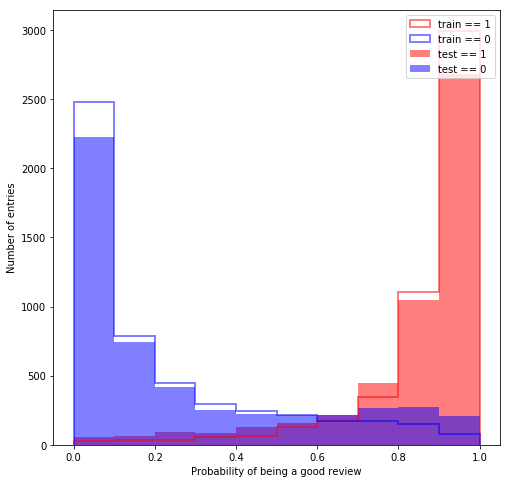

In [13]:
evaluate(X_test[:10000], y_test[:10000],X_train[:10000], y_train[:10000], model)

## LSTM with dropout

Recurrent Neural networks like LSTM generally have the problem of overfitting.

Dropout can be applied between layers using the Dropout Keras layer. We have done this easily by adding new Dropout layers between the Embedding and LSTM layers and the LSTM and Dense output layers. 

Alternately, dropout can be applied to the input and recurrent connections of the memory units with the LSTM precisely and separately.
Keras provides this capability with parameters on the LSTM layer, the dropout for configuring the input dropout and recurrent_dropout for configuring the recurrent dropout. For example, we can modify the first example to add dropout to the input and recurrent connections as follows:

`model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))`

## Task 2: Train and evaluate an LSTM model with dropout
* Instead of using two dropout layers, apply dropout to the input and recurrent connections of the LSTM model
* Train the model and plot the loss and accuracy over epochs
* Evaluate the performance of the model and compare it with the previous models

In [14]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 242,561
Trainable params: 242,561
Non-trainable params: 0
_________________________________________________________________
None


### Training

In [15]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=64)

Train on 17500 samples, validate on 7500 samples
Epoch 1/3
17500/17500 [==============================] - 225s 13ms/step - loss: 0.5642 - acc: 0.7061 - val_loss: 0.4781 - val_acc: 0.7676
Epoch 2/3
17500/17500 [==============================] - 217s 12ms/step - loss: 0.4055 - acc: 0.8246 - val_loss: 0.4214 - val_acc: 0.8073
Epoch 3/3
17500/17500 [==============================] - 228s 13ms/step - loss: 0.3703 - acc: 0.8447 - val_loss: 0.3958 - val_acc: 0.8276


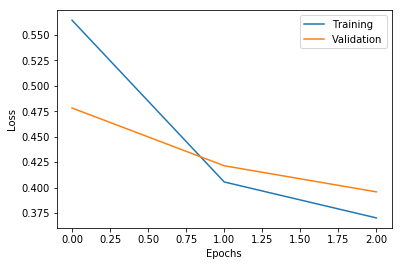

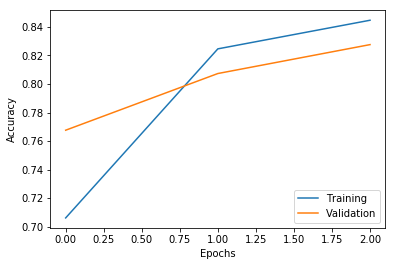

In [16]:
plot_history(history)

### Evaluation

('Test Loss:', 0.3926689309597015)
Accuracy: 0.83
Precision: 0.83
Recall: 0.83
Classification Report:
             precision    recall  f1-score   support

          0       0.84      0.81      0.83      5027
          1       0.82      0.84      0.83      4973

avg / total       0.83      0.83      0.83     10000



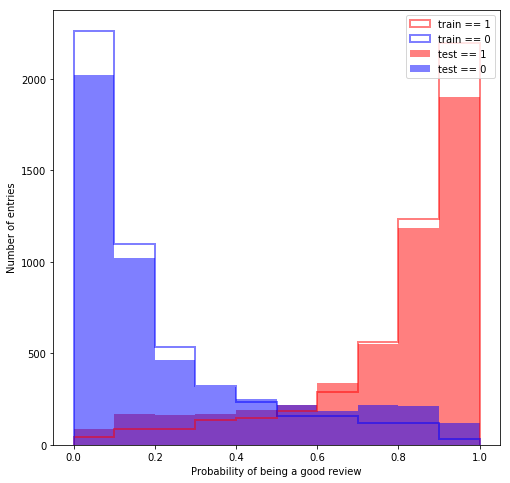

In [17]:
evaluate(X_test[:10000], y_test[:10000],X_train[:10000], y_train[:10000], model)

We can see that the LSTM specific dropout has a more pronounced effect on the convergence of the network than the layer-wise dropout. As above, the number of epochs was kept constant and could be increased to see if the skill of the model can be further lifted.

Dropout is a powerful technique for combating overfitting in your LSTM models and it is a good idea to try both methods, but you may bet better results with the gate-specific dropout provided in Keras.

## Convolutional LSTM

Convolutional neural networks excel at learning the spatial structure in input data.

The IMDB review data does have a one-dimensional spatial structure in the sequence of words in reviews and the CNN may be able to pick out invariant features for good and bad sentiment. This learned spatial features may then be learned as sequences by an LSTM layer.

We can easily add a one-dimensional CNN and max pooling layers after the Embedding layer which then feed the consolidated features to the LSTM. We can use a smallish set of 32 features with a small filter length of 3. The pooling layer can use the standard length of 2 to halve the feature map size.


## Task 3: Train and evaluate an LSTM model with a convolutional layer
* Add one convolutional layer and one maxpooling layer before the LSTM layer
* Train the model and plot the loss and accuracy over epochs
* Evaluate the performance of the model and compare it with the previous models

In [18]:
from keras.layers.convolutional import Conv1D,MaxPooling1D
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 245,665
Trainable params: 245,665
Non-trainable params: 0
_________________________________________________________________
None


### Training

In [19]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=64)

Train on 17500 samples, validate on 7500 samples
Epoch 1/3
17500/17500 [==============================] - 123s 7ms/step - loss: 0.5468 - acc: 0.6969 - val_loss: 0.3730 - val_acc: 0.8432
Epoch 2/3
17500/17500 [==============================] - 122s 7ms/step - loss: 0.3579 - acc: 0.8512 - val_loss: 0.3653 - val_acc: 0.8463
Epoch 3/3
17500/17500 [==============================] - 119s 7ms/step - loss: 0.3366 - acc: 0.8592 - val_loss: 0.3321 - val_acc: 0.8627


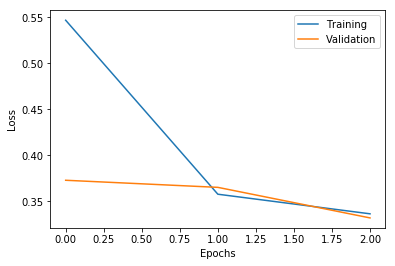

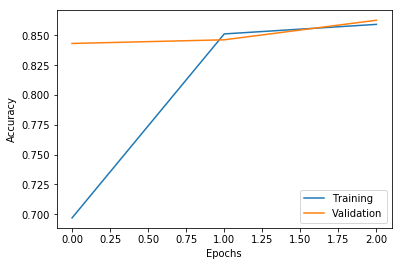

In [20]:
plot_history(history)

### Evaluation

('Test Loss:', 0.3300702913761139)
Accuracy: 0.86
Precision: 0.86
Recall: 0.86
Classification Report:
             precision    recall  f1-score   support

          0       0.85      0.89      0.87      5027
          1       0.88      0.84      0.86      4973

avg / total       0.86      0.86      0.86     10000



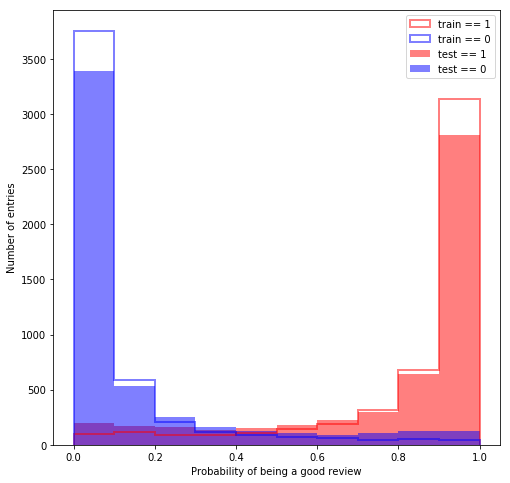

In [21]:
evaluate(X_test[:10000], y_test[:10000],X_train[:10000], y_train[:10000], model)

---

## Bonus: LSTM with convolutional input & recurrent transformation

[Convolutional LSTM Network: A Machine Learning Approach for
Precipitation Nowcasting](http://arxiv.org/abs/1506.04214v1) 

Based on https://github.com/keras-team/keras/blob/master/examples/conv_lstm.py

This network is used to predict the next frame of an artificially generated movie which contains moving squares.

#### Artificial Data Generation

Generate movies with `3` to `7` moving squares inside.

The squares are of shape $1 \times 1$ or $2 \times 2$ pixels, which move linearly over time.

For convenience we first create movies with bigger width and height (`80x80`) 
and at the end we select a $40 \times 40$ window.

In [22]:
# Artificial Data Generation
def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1),
                              dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[i, t, x_shift - w: x_shift + w,
                             y_shift - w: y_shift + w, 0] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the network to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1)**np.random.randint(0, 2)
                    noisy_movies[i, t,
                                 x_shift - w - 1: x_shift + w + 1,
                                 y_shift - w - 1: y_shift + w + 1,
                                 0] += noise_f * 0.1

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[i, t, x_shift - w: x_shift + w,
                               y_shift - w: y_shift + w, 0] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

### Model

In [23]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

We create a layer which take as input movies of shape `(n_frames, width, height, channels)` and returns a movie
of identical shape.

In [24]:
seq = Sequential()
seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   input_shape=(None, 40, 40, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer='adadelta')

### Train the Network

#### Beware: This takes time 

In [25]:
# Train the network
noisy_movies, shifted_movies = generate_movies(n_samples=1200)
seq.fit(noisy_movies[:1000], shifted_movies[:1000], batch_size=10,
        epochs=20, validation_split=0.05)

Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 2051s 2s/step - loss: 0.2899 - val_loss: 0.0970
Epoch 2/20
950/950 [==============================] - 2050s 2s/step - loss: 0.0295 - val_loss: 0.0134
Epoch 3/20
950/950 [==============================] - 2029s 2s/step - loss: 0.0175 - val_loss: 0.0336
Epoch 4/20
950/950 [==============================] - 2033s 2s/step - loss: 0.0039 - val_loss: 0.0029
Epoch 5/20
950/950 [==============================] - 2028s 2s/step - loss: 0.0016 - val_loss: 0.0012
Epoch 6/20
950/950 [==============================] - 2004s 2s/step - loss: 8.6522e-04 - val_loss: 7.6514e-04
Epoch 7/20
950/950 [==============================] - 1988s 2s/step - loss: 6.2943e-04 - val_loss: 6.0122e-04
Epoch 8/20
950/950 [==============================] - 1981s 2s/step - loss: 5.1458e-04 - val_loss: 5.2007e-04
Epoch 9/20
950/950 [==============================] - 1966s 2s/step - loss: 4.4904e-04 - val_loss: 4.5834e-04
Epoch

### Test the Network

In [26]:
# Testing the network on one movie
# feed it with the first 7 positions and then
# predict the new positions
which = 1004
track = noisy_movies[which][:7, ::, ::, ::]

for j in range(16):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)

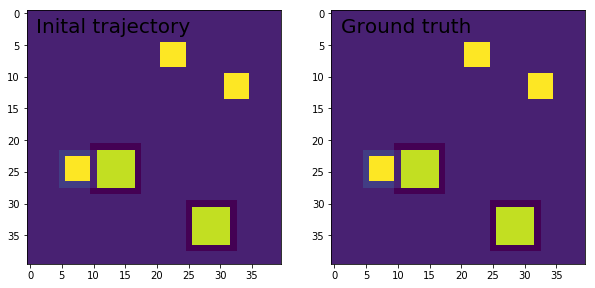

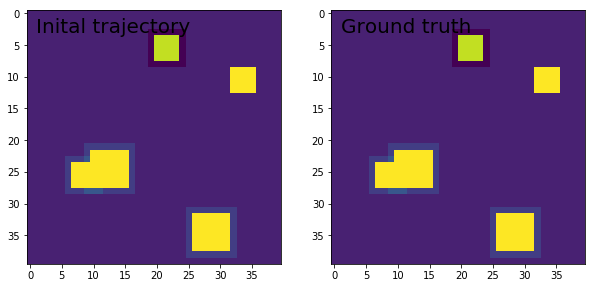

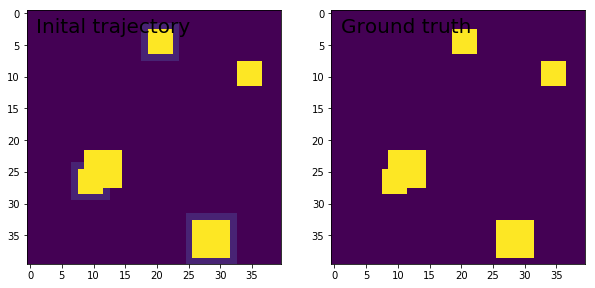

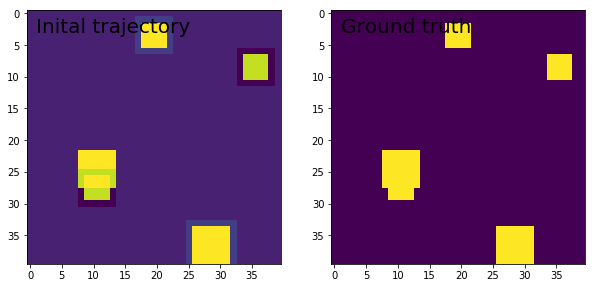

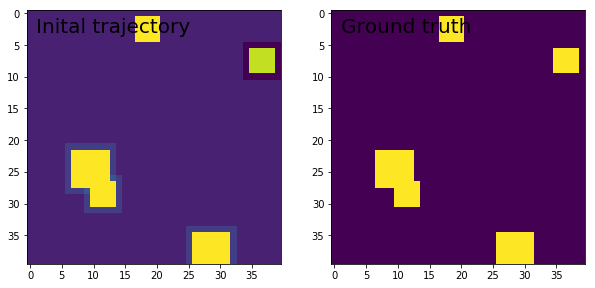

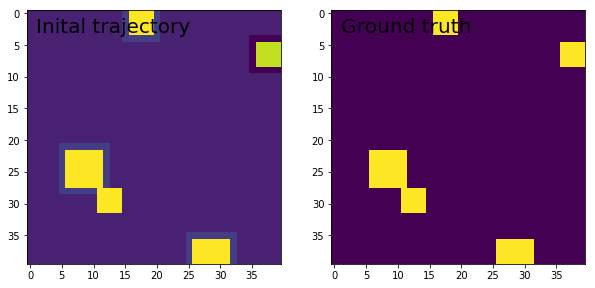

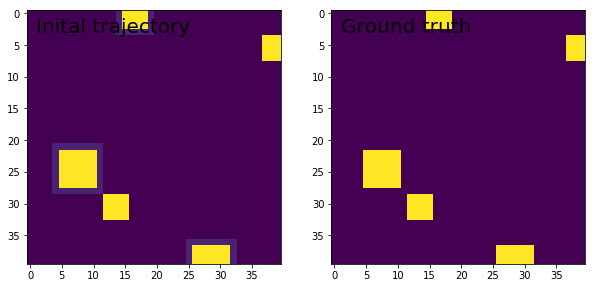

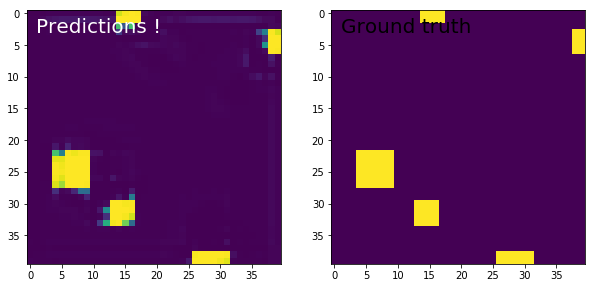

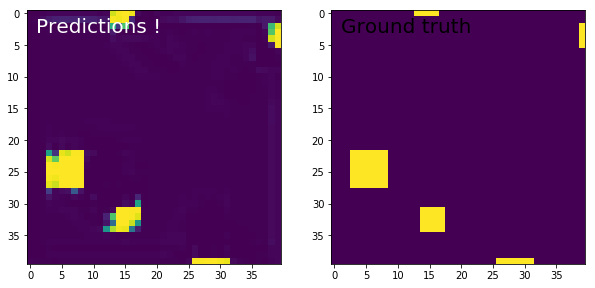

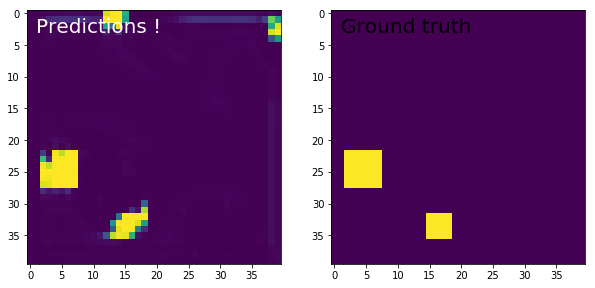

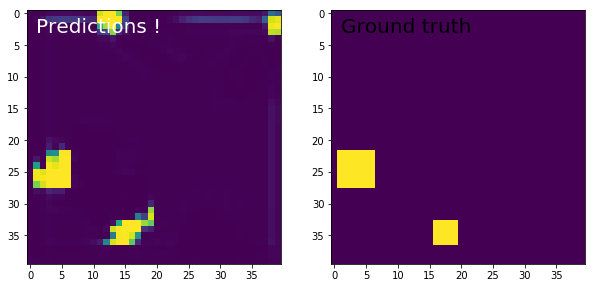

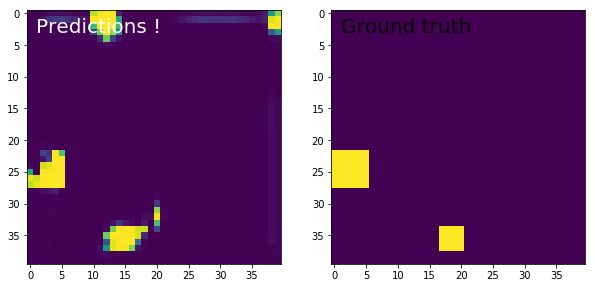

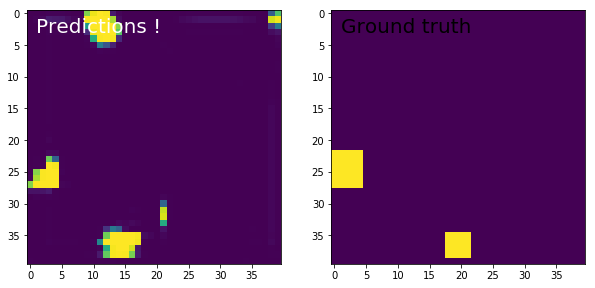

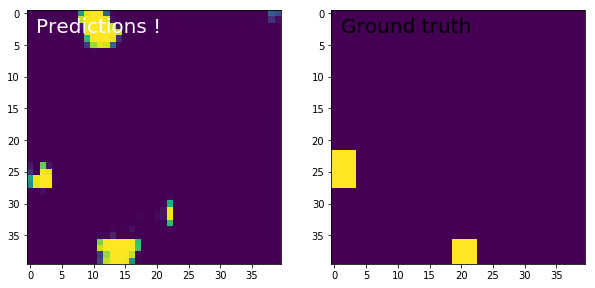

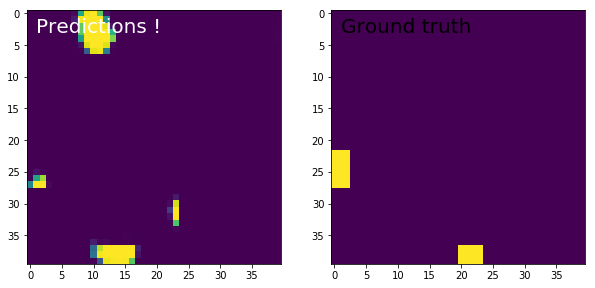

In [27]:
# And then compare the predictions
# to the ground truth
track2 = noisy_movies[which][::, ::, ::, ::]
for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, 'Predictions !', fontsize=20, color='w')
    else:
        ax.text(1, 3, 'Inital trajectory', fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
        toplot = shifted_movies[which][i - 1, ::, ::, 0]

    plt.imshow(toplot)
    plt.savefig('%i_animate.png' % (i + 1))